### 0. Import libraries ###

In [17]:
import os
import numpy as np
import rasterio as rio
import geopandas as gpd
from sys import exit
import geospatial_functions.geospatial_analysis as ga
#from rasterio.warp import Resampling
#import pandas as pd
#import matplotlib.pyplot as plt 

print('Done')

Done


### 0. Specify file paths ###

In [29]:
# ================ INPUTS AND CONFIGURATIONS (EDITION NEEDED) ================ 
# --- PART 1. common input files ---
root_dir = '/glade/u/home/hongli/scratch/2020_06_02HRUcomplexity/discretize'
# root_dir='/Users/hongli/Documents/proj/2020_06_01HRUcomplexity/discretize'
source_data_dir = os.path.join(root_dir, 'source_data')

huc12_shp = os.path.join(source_data_dir, 'west_huc12/WEST.huc12.shp')
huc12_field   = 'HUC12' #'HUC12int'     
Tohuc12_field = 'ToHUC'

dem_raster = os.path.join(source_data_dir, 'MERIT_Hydro_dem_NLDAS.tif') # large-domain DEM raster covering the case study area. Used for clipping.
dem_nodatavalue = -9999                                                 # the value for pixels to be considered as NoData. Obtained by checking dem_raster.

lc_raster = os.path.join(source_data_dir, 'nldas_landcover.tif')        # silimar with dem_raster, but for landcover.
lc_nodatavalue = 255                                                    # silimar with dem_nodatavalue.

soil_raster = os.path.join(source_data_dir, 'usda_mode_soilclass_vCompressed_NA_250m_ll.tif') # silimar with dem_raster, but for soil.
soil_nodatavalue = np.nan                                               # silimar with dem_nodatavalue.
    
# ---- PART 2. case study relevant inputs and configurations ----
# case = 'shoshone'                                                # user-specified case study name. Used to create a case study foler to store all the case study relevant files.
# outlet_hucid = '100800120304'                                    # huc12id of the outlet HUC12 of the case study area.
case = 'tuolumne'
outlet_hucid = '180400090504'

case_dir = os.path.join(root_dir, case)                          # case study directory. Used to store all the case study relevant files.
if not os.path.exists(case_dir): os.makedirs(case_dir)           # create case study folder if it doesn't exist.
rad_raster = os.path.join(case_dir, 'step9_merge_raw_Sw/sw.tif') # solar radiation raster for case study. Calcualted based on the reference: Allen et al., 2006. Agricultural and Forest Meteorology. 

# ---- PART 3. define GRU and HRU field names and data types ----
# note: Some avaialble dtypes for rasterio: 'int16', 'int32', 'float32', 'float64'. No 'int64'!
# reference: https://test2.biogeo.ucdavis.edu/rasterio/_modules/rasterio/dtypes.html
gruNo_field = 'gruNo'       # field name of gru number, e.g.,1,2,3...
gruNo_field_dtype = 'int32' # used to save gruNo raster. 
gruName_field = 'gruId'     # field name of gru name, e.g., 100800120101. 

hruNo_field = 'hruNo'       # field name of hru number, e.g.,1,2,3...
hruNo_field_dtype = 'int32' # used to save hruNo raster. 
hruName_field = 'hruId'     # field name of hru name, e.g., 10080012010101, 100800120102. 
hruArea_field = 'areaSqm'   # field name of hru area, used in small HRU elimination

# ---- PART 4. define common projection, nodata value, reference raster ----
proj4="+proj=aea +lat_1=20 +lat_2=60 +lat_0=40 +lon_0=-96 +x_0=0 +y_0=0 +ellps=GRS80 +datum=NAD83 +units=m no_defs"
dst_crs = rio.crs.CRS.from_string(proj4)
## Albers Equal Area Conic Projection. 
## reference 1: https://gisgeography.com/conic-projection-lambert-albers-polyconic/
## reference 2: https://epsg.io/102008

nodatavalue = -9999   # used in raster generatation

# ---- PART 5. define HRU elimination threshold (two options: value, fraction) ----
# hru_thld_type = 'value'
# hru_thld = 10**6 #1km2

hru_thld_type = 'fraction'
hru_thld = 0.05  # partial of the gru area


# ================ INTERMEDIATE FILES (NO EDITION NEEDED) ================ 
dem_raster_prj = os.path.join(os.path.dirname(dem_raster), os.path.basename(dem_raster).split('.tif')[0]+'_prj.tif')
lc_raster_prj = os.path.join(os.path.dirname(lc_raster), os.path.basename(lc_raster).split('.tif')[0]+'_prj.tif')
soil_raster_prj = os.path.join(os.path.dirname(soil_raster), os.path.basename(soil_raster).split('.tif')[0]+'_prj.tif')

dem_crop = os.path.join(case_dir, 'dem_crop.tif')               # DEM raster of case study. Cropped from the projected large-domain DEM raster.
refraster = dem_crop                                            # reference raster, used in vector rasterization and resample.
dem_crop_buf = os.path.join(case_dir, 'dem_crop_buf.tif')       # buffered DEM raster of case study. 
dem_class_raster_basename = os.path.join(case_dir, 'dem_class') # basename for DEM class files (e.g., 0:low elevation. 1: high elevation).
dem_value_raster_basename = os.path.join(case_dir, 'dem_value') # basename for DEM value files (e.g., average DEM per class).

slope_raster = os.path.join(case_dir, 'slope.tif')             # slope raster, calcualted based on dem_crop.
aspect_raster = os.path.join(case_dir, 'aspect.tif')           # aspect raster, calcualted based on dem_crop.

lc_crop = os.path.join(case_dir, 'landcover_crop.tif')         # landcover raster of case study. Cropped from the projected large-domain landcover raster.
lc_crop_resample = os.path.join(case_dir, 'landcover_crop_resample.tif') # resampled landcover raster according to the layout of refraster. 
lc_class_raster = os.path.join(case_dir, 'landcover_class.tif')# landcover class raster (e.g., canopy, non-canopy).

soil_crop = os.path.join(case_dir, 'soil_crop.tif')         # soil raster of case study.

gru_shp = os.path.join(case_dir, 'huc12.shp')               # GRU shapefile of case study. Cropped from the large-domain HUC12 shapefile.
huc12_list_txt = 'huc12Ids.txt'                                    # list of HUC12 ids.
gru_shp_prj = os.path.join(case_dir, 'gru_prj.shp')         # project GRU shapefile.
gru_raster = os.path.join(case_dir, 'gru.tif')              # project GRU raster file.
gru_corr_txt=os.path.join(case_dir, 'gruNo_HUC12_corr.txt') # correspondence between HUC12 and gru number (for recrod).
 
rad_class_raster_basename = os.path.join(case_dir, 'rad_class') # basename for radiation class files (e.g., 0:low. 1:high).
rad_value_raster_basename = os.path.join(case_dir, 'rad_value') # basename for radiation value files (e.g., average radiation per class).

print('Done')

Done


### 0. Project large rasters (once for all) ###

In [3]:
# # --- PART 1. reproject dem, landcover, and soilClass rasters --- 
# print('PART 1. reproject dem and landcover rasters')
# ga.reproject_raster(dem_raster, dem_raster_prj, dst_crs, Resampling.bilinear)    # re-project dem raster
# ga.reproject_raster(lc_raster, lc_raster_prj, dst_crs, Resampling.nearest)       # re-project land cover raster
# ga.reproject_raster(soil_raster, soil_raster_prj, dst_crs, Resampling.nearest)   # re-project soilClass raster

# print('Done')

PART 1. reproject dem and landcover rasters
Done


### 1. Clip GRU shapefile for case study ###

Round 1. Totally 4 HUCs are found.
Round 2. Totally 7 HUCs are found.
Round 3. Totally 12 HUCs are found.
Round 4. Totally 13 HUCs are found.


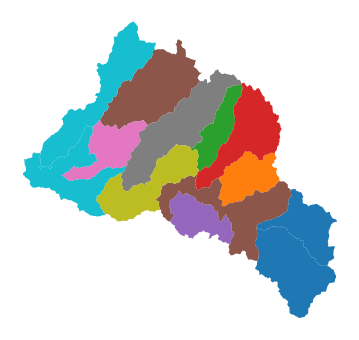

Done


In [14]:
# ---- PART 1. read large-domain HUC12 shapefile ---- 
data = gpd.read_file(huc12_shp)
# check whether two useful columns (huc12_field, Tohuc12_field) are in huc12_shp.
if not huc12_field in data.columns.values:
    exit(huc12_field+' column does not exist in shapefile.')
else:
    hucs = data[huc12_field].values
if not Tohuc12_field in data.columns.values:
    exit(Tohuc12_field+' column does not exist in shapefile.')
else:
    tohucs = data[Tohuc12_field].values
# extract only the useful columns to save data memory.
data = data[[huc12_field,Tohuc12_field,'geometry']] 

# ---- PART 2. search upstream HUCs ---- 
# method 1: search upstream hucs base on the most downstream hucId
upstream_hucs = [outlet_hucid]                              # list of upstream hucs. initiate with outlet_hucid
huc_found = np.unique(hucs[np.where(tohucs==outlet_hucid)]) # find all the upstream hucs that drain to outlet_hucid.
upstream_hucs.extend(list(huc_found))                            # add the found upstream hucs of outlet_hucid to upstream_hucs list. 
round_num = 0                                                    # record the round number of searching.

while len(huc_found) != 0: # terminate searching upstream hucs until no one can be found any more.

    round_num = round_num+1
    print("Round %d. Totally %d HUCs are found." % (round_num, len(upstream_hucs)))

    # search upstream hucs
    huc_found_next = []
    for huc_i in huc_found:
        huc_found_next.extend(list(hucs[np.where(tohucs==huc_i)]))
    huc_found_next = ga.unique(huc_found_next)

    # identify if the found HUCs exist in upstrm_hucs
    huc_found = [huc for huc in huc_found_next if not huc in upstream_hucs]
    upstream_hucs.extend(huc_found)

#     # method 2: manually add upstream_hucs when the list of upstream hucs is known. 
#     # here huc12 list is from the bighorn model forcing nc file (hurId).
#     upstream_hucs= np.loadtxt('/glade/u/home/andywood/proj/SHARP/wreg/bighorn/prep/lists/hucIds.06279940.txt',dtype=int)
#     upstream_hucs=[100800120304, 100800120302, 100800120303, 100800120301,100800120209, 100800120207, 100800120204, 100800120205, 100800120208,
#                 100800120206, 100800120105, 100800120201, 100800120202, 100800120203,100800120101, 100800120102, 100800120103, 100800120104]

# ---- PART 3. save upstream HUC12 to text and shapefile ---- 
np.savetxt(os.path.join(case_dir, huc12_list_txt), upstream_hucs, fmt='%s')
data[data[huc12_field].isin(upstream_hucs)].to_file(os.path.join(case_dir,gru_shp))
 
# ---- PART 4. plot found HUC12s ---- 
ga.plot_vector(os.path.join(case_dir,gru_shp), huc12_field)

print('Done')

### 1. Prepare rasters by crop, resample and classify ###

In [15]:
# --- PART 1. crop useful rasters for HRU generation and zonal statistics ---
print('PART 1. crop rasters')
# (1) reproject basin vector.
ga.reproject_vector(gru_shp, gru_shp_prj, dst_crs) # re-project gru shapefile
# (2) based on original basin extent, crop all the useful rasters (e.g., dem, landcover, soil).
ga.crop_raster(dem_raster_prj,gru_shp_prj,dem_nodatavalue,dem_crop)
ga.crop_raster(lc_raster_prj,gru_shp_prj,lc_nodatavalue,lc_crop) # 255 is nodatavalue for landcover raster
ga.crop_raster(soil_raster_prj,gru_shp_prj,soil_nodatavalue,soil_crop) # nan is nodatavalue for soil raster

# --- PART 2. resample HRU-generation needed rasters to refraster ---
print('PART 2. resample rasters')
# (1) landcover
ga.resample_raster(lc_crop,refraster,lc_crop_resample) 

# --- PART 3. classify HRU-generation needed rasters that are independent of any other inputs ---
print('PART 3. classify rasters')
# relassify landcover raster 
# Note: here we make only two classes: crop vs. non-crop
# Crop class includes: 0 Evergreen needleleaf forests, 1 Evergreen broadleaf forests, 
# 2 Deciduous needleleaf forests, 3 Deciduous broadleaf forests, 4 Mixed forests, 6 Closed shrublands, 7 Woody savannas.  
ga.classify_discrete_landcover(lc_crop_resample, lc_class_raster, nodatavalue)
  
# --- PART 4. rasterize gru ---
print('PART 4. rasterize gru')
infield = huc12_field
infield_rename = gruName_field
ga.rasterize_gru_vector(gru_shp_prj,infield,gruName_field,gruNo_field,gruNo_field_dtype,
                        refraster,gru_raster,gru_corr_txt,nodatavalue)

# --- PART 5. calculate slope and aspect if needed ---
print('PART 5. calculate slope and aspect')
ga.calculate_slope_aspect(dem_crop, slope_raster, aspect_raster)

print('Done')

PART 1. crop rasters
PART 2. resample rasters
PART 3. classify rasters
PART 4. rasterize gru
PART 5. calculate slope and aspect
Done


### 2. Generate HRU at different complexity levels ###

In [30]:
level_num = 3
for level in range(1,1+level_num):

    print('--- Complexity level %d ---' %(level))
    
    #  --- PART 1. define hru complexity level dependent files --- 
    print('PART 1. define files')
    hru_str = 'hru'+'_lvl' + str(level)
    hru_elmn_str = hru_str+'_elmn'       
    hru_raster = os.path.join(case_dir, hru_str+'.tif')            # original HRU
    hru_vector = os.path.join(case_dir, hru_str+'.shp')
    hru_raster_elmn = os.path.join(case_dir, hru_elmn_str+'.tif')  # simplified HRU
    hru_vector_elmn = os.path.join(case_dir, hru_elmn_str+'.shp')    

    dem_classif_trigger = 300 # Elvation difference value of triggering classification.
    dem_bins = 'median'
    dem_class_raster=dem_class_raster_basename+'_lvl'+str(level)+'.tif'
    dem_value_raster=dem_value_raster_basename+'_lvl'+str(level)+'.tif'
    
    rad_classif_trigger = None
    rad_bins = 'median'
    rad_class_raster=rad_class_raster_basename+'_lvl'+str(level)+'.tif'
    rad_value_raster=rad_value_raster_basename+'_lvl'+str(level)+'.tif'
    
#     # level 1: use only elevation bands in HRU generation
#     if level == 1: 
#         # (1) classify elevation raster per gru
#         ga.classify_continuous_raster(dem_crop, gru_raster, dem_classif_trigger, dem_bins, 
#                                       dem_class_raster, dem_value_raster, nodatavalue)        
#         # (2) define hru discretization files
#         raster_list = [gru_raster,dem_class_raster]
#         raster_fieldname_list = [gruNo_field,'elevClass']
    
#     # level 2: use elevation bands and landcover classes in HRU generation
#     elif level == 2: 
#         # (1) classify elevation raster per gru
#         ga.classify_continuous_raster(dem_crop, gru_raster, dem_classif_trigger, dem_bins, 
#                                       dem_class_raster, dem_value_raster, nodatavalue)        
#         # (2) define hru discretization files
#         raster_list = [gru_raster, dem_class_raster, lc_class_raster]
#         raster_fieldname_list = [gruNo_field, 'elevClass', 'lcClass']
    
#      # level 3: use elevation bands, radiation bands, landcover classes in HRU generation
#     elif level == 3:
#         # (1) classify elevation raster per gru
#         ga.classify_continuous_raster(dem_crop, gru_raster, dem_classif_trigger, dem_bins, 
#                                       dem_class_raster, dem_value_raster, nodatavalue)        
#         # (2) classify radiation raster per gru
#         ga.classify_continuous_raster(rad_raster, gru_raster, rad_classif_trigger, rad_bins, 
#                                       rad_class_raster, rad_value_raster, nodatavalue)        
#         # (3) define hru discretization files
#         raster_list = [gru_raster, dem_class_raster, rad_class_raster, lc_class_raster]
#         raster_fieldname_list = [gruNo_field, 'elevClass', 'radClass', 'lcClass']

#     # --- PART 2. genearte HRU based on gru and elevation class ---
#     print('PART 2. genearte HRU')
#     ga.define_hru(raster_list, raster_fieldname_list, gru_raster, gru_corr_txt, gruNo_field, gruName_field,
#                   nodatavalue, hru_raster, hru_vector, hruNo_field, hruNo_field_dtype, hruName_field)
#     ga.plot_vector(hru_vector, hruName_field) # plot for check

#     # --- PART 3. calculate zonal area ---
#     print('PART 3. calculate zonal area')
#     in_gpd = gpd.read_file(hru_vector)
#     in_gpd['areaSqm'] = in_gpd.area
#     in_gpd.to_file(hru_vector)

#     # --- PART 4. eliminate small HRUs ---
#     print('PART 4. eliminate small HRUs')
#     # method 2: change HRU attribute to its' largest neighbor's HRU
#     ga.eliminate_small_hrus_neighbor(hru_vector, hru_thld_type, hru_thld, gruNo_field, gruName_field, hruNo_field, hruNo_field_dtype, 
#                                      hruName_field, hruArea_field, raster_fieldname_list, refraster, hru_vector_elmn, hru_raster_elmn,
#                                      nodatavalue)

    # --- PART 5. calculate zonal statistics ---
    print('PART 5. calculate zonal statistics ')
    for invector in [hru_vector,hru_vector_elmn]:
        
        # (1) define invector dependent files 
        hru_attrb_elev = os.path.join(case_dir, os.path.basename(invector).split('.shp')[0]+'_attrb_elevation.tif')        
        hru_attrb_slp = os.path.join(case_dir, os.path.basename(invector).split('.shp')[0]+'_attrb_slope.tif')        
        hru_attrb_lc = os.path.join(case_dir, os.path.basename(invector).split('.shp')[0]+'_attrb_landcover.tif')        
        hru_attrb_soil = os.path.join(case_dir, os.path.basename(invector).split('.shp')[0]+'_attrb_soil.tif')        
        
        # (2) elevation zonal statistics 
        ga.zonal_statistic(dem_crop, invector, hruNo_field, hruNo_field_dtype, refraster, 'mean', hru_attrb_elev,
                           nodatavalue, output_column_prefix='elev')

        # (3) slope zonal statistics 
        ga.zonal_statistic(slope_raster, invector, hruNo_field, hruNo_field_dtype, refraster, 'mean', hru_attrb_slp,
                           nodatavalue, output_column_prefix='slope')

        # (4) landcover zonal statistics 
        ga.zonal_statistic(lc_crop_resample, invector, hruNo_field, hruNo_field_dtype, refraster, 'mode', hru_attrb_lc,
                           nodatavalue, output_column_prefix='vegType')        
        
        # (5) soil zonal statistics 
        ga.zonal_statistic(soil_crop, invector, hruNo_field, hruNo_field_dtype, refraster, 'mode', hru_attrb_soil,
                           nodatavalue, output_column_prefix='soilType')        
        
        # -------- post-process attributes for SUMMA ---------
        # (6) landcover and soil types 
        # convert landcover int to [1,17] range 
        # change soilType from float to int (because source soilType is float)
        in_gpd = gpd.read_file(invector)
        in_gpd['vegType'] = in_gpd['vegType']+1
        in_gpd['soilType'] = in_gpd['soilType'].astype('int')
        in_gpd.to_file(invector)
        
        # (7) convert landcover int to string for easy understanding
        lcClass_list = [ 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 255]
        lcValue_list = ['Evergreen needleleaf forests', 'Evergreen broadleaf forests', 'Deciduous needleleaf forests',
                        'Deciduous broadleaf forests', 'Mixed forests', 'Closed shrublands', 'Open shrublands', 
                        'Woody savannas', 'Savannas', 'Grasslands', 'Permanent wetlands', 'Croplands', 
                        'Urban and built-up lands', 'Cropland/natural vegetation mosaics', 'Snow and ice', 
                        'Barren', 'Water bodies', 'None']
        in_gpd = gpd.read_file(invector)
        in_gpd['landcover'] = ""
        for irow, row in in_gpd.iterrows():
            lcClass = in_gpd.loc[irow,'vegType'] 
            lcValue=lcValue_list[lcClass_list.index(lcClass)]
            in_gpd.at[irow,'landcover'] = lcValue
        in_gpd['landcover'] = in_gpd['landcover'].astype('str')
        in_gpd.to_file(invector)

        # (8) convert slope to tan_slope 
        in_gpd = gpd.read_file(invector)
        in_gpd['tan_slope'] = np.tan(in_gpd['slope'])
        in_gpd.to_file(invector)

        # (9) calculate contourLength (meter)
        # assuming the hru area is a circle and taking the radius as contourLength.
        in_gpd = gpd.read_file(invector)
        in_gpd['contourLength'] = np.power(in_gpd['areaSqm']/np.pi,0.5)
        in_gpd.to_file(invector)

        # (10) calculate centroid lat/lon (degree)
        in_gpd = gpd.read_file(invector)
        in_gpd_wgs84 = in_gpd.copy()
        in_gpd_wgs84 = in_gpd_wgs84.to_crs("EPSG:4326")
        def getXY(pt):
            return (pt.x, pt.y)
        centroidseries = in_gpd_wgs84['geometry'].centroid
        in_gpd['longitude'],in_gpd['latitude']=[list(t) for t in zip(*map(getXY, centroidseries))]
        in_gpd.to_file(invector)

    # --- PART 6. save as gpkg ---
    invector_gpkg = os.path.join(case_dir, os.path.basename(invector).split('.shp')[0]+'.gpkg')
    in_gpd = gpd.read_file(invector)
    in_gpd.to_file(invector_gpkg, driver="GPKG")
    
print('Done')

--- Complexity level 1 ---
PART 1. define files
PART 5. calculate zonal statistics 


<ipython-input-30-222384665d9b>:142: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroidseries = in_gpd_wgs84['geometry'].centroid


--- Complexity level 2 ---
PART 1. define files
PART 5. calculate zonal statistics 
--- Complexity level 3 ---
PART 1. define files
PART 5. calculate zonal statistics 
Done


In [27]:
import geopandas as gpd
invector = '/glade/u/home/hongli/scratch/2020_06_02HRUcomplexity/discretize/shoshone/hru_lvl1_elmn.shp'
in_gpd = gpd.read_file(invector)
in_gpd

,hruNo,hruId,gruId,gruNo,elevClass,areaSqm,landcover,tan_slope,contourLen,longitude,latitude,elev,slope,vegType,soilType,contourL_1,geometry
0,1,10080012010101,100800120101,1,1,3.250235e+07,Permanent wetlands,-1.151228,3216.491977,-110.067209,44.547391,2491.389648,17.993975,11,3,3216.491977,"POLYGON ((-1046586.907 617114.692, -1046441.94..."
1,2,10080012010102,100800120101,1,2,3.250761e+07,Permanent wetlands,-0.061705,3216.751906,-110.085804,44.550378,2868.368896,21.929522,11,3,3216.751906,"POLYGON ((-1044412.511 618564.289, -1044122.59..."
2,3,10080012010201,100800120102,2,1,2.500585e+07,Evergreen broadleaf forests,2.124631,2821.278055,-110.047348,44.511133,2471.625732,16.838850,2,3,2821.278055,"POLYGON ((-1044919.870 612113.582, -1044702.43..."
3,4,10080012010202,100800120102,2,2,2.500585e+07,Permanent wetlands,0.427190,2821.278055,-110.084235,44.507584,2842.218750,22.394873,11,3,2821.278055,"POLYGON ((-1044484.991 613200.779, -1044050.11..."
4,5,10080012010301,100800120103,3,1,4.699104e+07,Evergreen broadleaf forests,0.574996,3867.520166,-110.047550,44.466138,2442.920410,19.371387,2,3,3867.520166,"POLYGON ((-1043107.874 609286.867, -1042890.43..."
5,6,10080012010302,100800120103,3,2,4.699104e+07,Evergreen broadleaf forests,1.022974,3867.520166,-110.074702,44.448629,2828.455566,22.787903,2,3,3867.520166,"MULTIPOLYGON (((-1047021.786 605155.515, -1046..."
6,7,10080012010401,100800120104,4,1,3.929491e+07,Evergreen broadleaf forests,-0.258697,3536.659209,-109.893111,44.540805,2556.748779,18.596409,2,3,3536.659209,"MULTIPOLYGON (((-1038179.243 607039.991, -1038..."
7,8,10080012010402,100800120104,4,2,3.930016e+07,Permanent wetlands,1.619895,3536.895609,-109.864320,44.562209,2987.069580,23.008884,11,3,3536.895609,"MULTIPOLYGON (((-1026799.905 618274.370, -1026..."
8,9,10080012010501,100800120105,5,1,8.628070e+07,Permanent wetlands,-9.213678,5240.610500,-109.934491,44.578056,2465.392822,20.528463,11,3,5240.610500,"POLYGON ((-1029989.019 625594.836, -1029771.58..."
9,10,10080012010502,100800120105,5,2,8.628070e+07,Permanent wetlands,-1.947479,5240.610500,-109.906796,44.611707,2952.692139,24.036322,11,3,5240.610500,"MULTIPOLYGON (((-1041223.398 606460.152, -1041..."


In [28]:
in_gpd.area

0     3.250235e+07
1     3.250761e+07
2     2.500585e+07
3     2.500585e+07
4     4.699104e+07
5     4.699104e+07
6     3.929491e+07
7     3.930016e+07
8     8.628070e+07
9     8.628070e+07
10    7.485470e+07
11    7.485470e+07
12    7.679843e+07
13    7.680369e+07
14    2.123921e+07
15    2.123921e+07
16    5.607930e+07
17    5.608455e+07
18    2.556796e+07
19    2.557321e+07
20    6.945428e+07
21    6.945428e+07
22    7.024228e+07
23    7.024228e+07
24    5.980916e+07
25    5.981442e+07
26    6.401708e+07
27    6.402234e+07
28    3.352150e+07
29    3.352675e+07
30    7.659355e+07
31    7.659881e+07
32    6.274578e+07
33    6.274578e+07
34    8.969011e+07
35    8.969011e+07
dtype: float64

In [12]:
x

[-110.06720851675526,
 -110.08580441614401,
 -110.04734786653736,
 -110.08423471868412,
 -110.04755044549552,
 -110.07470201971535,
 -109.89311052767874,
 -109.86431983341757,
 -109.93449125451893,
 -109.90679640634514,
 -109.97229602338545,
 -110.0019169590033,
 -109.87386230361548,
 -109.88425210306302,
 -109.79736056351099,
 -109.79944925276891,
 -109.86396737217909,
 -109.90497223435538,
 -109.70642852415665,
 -109.75781494411187,
 -109.7349129977526,
 -109.76594383899806,
 -109.66777621702651,
 -109.67409288403199,
 -109.66799164942168,
 -109.69655437200878,
 -109.72769102457788,
 -109.77484090184983,
 -109.52803478533306,
 -109.55587324556943,
 -109.5672725562669,
 -109.57670924547452,
 -109.39175546175477,
 -109.4692886809214,
 -109.42292775880722,
 -109.44902635668068]